In [1]:
import cnot_network

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sbs
import numpy as np
sbs.set_context("paper")
sbs.set_theme()
sbs.set_style("dark")

from surface_code_routing.tikz_utils import tikz, tex

sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
    
def plt_data_multi(data, x_axis, y_axis, **targets):
    idx_map = {j:i for i, j in enumerate(data)}
    rev_map = {j:i for i, j in idx_map.items()}

    iters = zip(*[iter(data[rev_map[i]]) for i, _ in enumerate(data)])

    x = []
    y = []
    for it in iters:
        checks = True
        for targ in targets:
            if it[idx_map[targ]] != targets[targ]:
                checks = False
        if not checks:
            continue
            
        x.append(it[idx_map[x_axis]])
        y.append(it[idx_map[y_axis]])
    return {'x':x, 'y':y}

In [2]:
from functools import partial
from surface_code_routing.lib_instructions import T_Factory, Toffoli, T_gate

toff_height = 14
toff_width = toff_height

qcb_size = 32

t_factory_l1 = T_Factory()
toffoli_gate = Toffoli

t_factory_l2 = T_Factory(t_factory_l1, height=8, width=10, t_gate=T_gate(t_factory_l1))
t_gate_l2 = T_gate(factory=t_factory_l2)

t_factory_l3 = T_Factory(t_factory_l2, height=11, width=12, t_gate=T_gate(t_factory_l2))
t_gate_l3 = T_gate(factory=t_factory_l3)

extern_toffoli_l1 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l1)
extern_toffoli_l2 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l2)
extern_toffoli_l3 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l3)

# Raw T injection sites
ccz_factory_l1 = cnot_network.CCZ_factory(6, 4, t_factory=None)
ccz_factory_l2 = cnot_network.CCZ_factory(9, 7, t_factory=t_factory_l1)
ccz_factory_l3 = cnot_network.CCZ_factory(11, 11, t_factory=t_factory_l2)

t_factories = (t_factory_l1, t_factory_l2, t_factory_l3)
extern_toffolis = (extern_toffoli_l1, extern_toffoli_l2, extern_toffoli_l3)
ccz_factories = (ccz_factory_l1, ccz_factory_l2, ccz_factory_l3)

In [3]:
from functools import partial

import qmpa
from surface_code_routing.dag import DAG
from surface_code_routing.symbol import Symbol 
from surface_code_routing.instructions import INIT, CNOT, MEAS, X, Hadamard
from surface_code_routing.lib_instructions import Toffoli, T, T_Factory

import cnot_network

from surface_code_routing.compiled_qcb import compile_qcb

# Default Gates
GATE_MAP = {
    qmpa.gates.X : X,
    qmpa.gates.CNOT : CNOT,
    qmpa.gates.Toffoli : Toffoli,
}

def circ_to_dag(qmpa_circ, dag_symbol, gate_map=GATE_MAP, toffoli=Toffoli, init=True):

    dag = DAG(dag_symbol)

    # Local copy
    gate_map = dict(gate_map)
    
    gate_map[qmpa.gates.Toffoli] = toffoli
    
    if init:
        for i in range(qmpa_circ.allocator.max_mem):
            dag.add_gate(INIT(f'reg_{i}'))

    for gate in qmpa_circ.circuit:
        dag_gate = gate_map.get(type(gate), None)
        if dag_gate is None:
            continue

        args = gate.qargs()
        dag.add_gate(
                dag_gate(
                    *list(
                        map(lambda x: "reg_{x}".format(x=x), args)
                        )
                    )
                )
    return dag 

In [4]:
import numpy as np
from functools import reduce, partial

from surface_code_routing.dag import DAG
from surface_code_routing.symbol import Symbol 
from surface_code_routing.instructions import INIT, CNOT, MEAS, X, Hadamard
from surface_code_routing.lib_instructions import T_Factory, CSWAP

from surface_code_routing.compiled_qcb import compile_qcb

import qmpa

def qmpa_in_place_operation(operation, readout_assert, *values, register_size = None):
    assert all(lambda x: type(x) is int for x in values)

    if register_size is None:
        register_size = int(np.ceil(np.log2(max(values))))

    circ = qmpa.circuit.Circuit()
    
    reg_carry = circ.register(1, 'carry')
    registers = [circ.register(register_size + i, 'reg_{}'.format(i), value) for i, value in enumerate(values)]
               
    reduce(partial(operation(circ), reg_carry=reg_carry), registers) 
    
    return circ


def qmpa_multiplication(*values, register_size = None):
    assert all(lambda x: type(x) is int for x in values)


    if register_size is None:
        register_size = int(np.ceil(np.log2(max(values)))) + 1

    circ = qmpa.circuit.Circuit()
    
    reg_carry = circ.register(1, 'carry')
    registers = [circ.register(register_size, 'reg_{}'.format(i), value) for  i, value in enumerate(values)]
              
    prev_reg = registers[0]
    for register in registers[1:]:
       prev_reg = circ.multiply(prev_reg, register)
        
    assert reduce(lambda x, y: x * y, values) == circ.readout(prev_reg)[0]
    return circ


qmpa_addition = partial(qmpa_in_place_operation, lambda x: x.add, lambda vals: reduce(lambda x, y: x + y, vals))
qmpa_subtraction = partial(qmpa_in_place_operation, lambda x: x.subtract, lambda vals: reduce(lambda x, y: x - y, vals))

def qmpa_division(*values, register_sizes = None):
    assert all(lambda x: type(x) is int for x in values)


    if register_sizes is None:
        register_sizes = [int(np.ceil(np.log2(i))) + 1 for i in values]

    circ = qmpa.circuit.Circuit()
    
    reg_carry = circ.register(1, 'carry')
    registers = [circ.register(register_size, 'reg_{}'.format(i), value) for  i, (value, register_size) in enumerate(zip(values, register_sizes))]
              
    prev_reg = registers[0]
    for register in registers[1:]:
       prev_reg = circ.divide(prev_reg, register) 
    
    return circ

In [5]:
toffoli_gate = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

def CCPY(n_qubits, height, width, *externs, toffoli_gate=Toffoli, **kwargs):
    assert (width >= n_qubits * 2 + 1)
    dag = DAG(Symbol(
        f"CCPY",
        tuple(['ctrl'] + [f'q_{i}' for i in range(n_qubits)]),
        tuple(['ctrl'] + [f'q_{i}' for i in range(n_qubits)] + [f'o_{i}' for i in range(n_qubits)]))
             )
    for i in range(n_qubits):
        dag.add_gate(toffoli_gate('ctrl', f'q_{i}', f'o_{i}'))
    return compile_qcb(dag, height, width, *externs, **kwargs)

In [6]:
def Adder(n_qubits, height, width, *externs, toffoli_gate=toffoli_gate):
    n_qubits = 3
    qmpa_obj = qmpa_addition(1 << n_qubits, 1 << n_qubits)
    input_registers = [f'reg_{i}' for i in range(n_qubits * 2)]
    output_registers =  [f'reg_{i}' for i in range(qmpa_obj.allocator.max_mem)]
    dag = circ_to_dag(
        qmpa_obj,
        Symbol(f'ADD_{n_qubits}', input_registers, output_registers), 
        toffoli=toffoli_gate,
        init=False)
    return compile_qcb(dag, height, width, *externs)

In [7]:
def Multiplication(n_qubits, height, width, *externs, adder=None, ccpy=None, **kwargs):

    dag = DAG(f"MUL_{n_qubits}")
    
    for i in range(n_qubits):
        dag.add_gate(INIT(f'a_{i}'))
        dag.add_gate(INIT(f'b_{i}'))
    
    reg_a = [f'a_{i}' for i in range(n_qubits)]
    reg_b = [f'b_{i}' for i in range(n_qubits)]
    
    for i in range(2 * n_qubits):
        dag.add_gate(INIT(f't_{i}'))
        dag.add_gate(INIT(f'cpy_{i}'))
    
    reg_cpy = [f'cpy_{i}' for i in range(2 * n_qubits)]
    reg_target = [f't_{i}' for i in range(2 * n_qubits)]
    
    for i in range(n_qubits):

        # Conditional Copy
        dag.add_gate(ccpy(
            tuple(
                [reg_b[i]]
                + reg_a
            ),
            tuple(
                [reg_b[i]]
                + reg_a
                + reg_cpy[i:i + n_qubits]
            )
        ))

        # Start with a single adder
        dag.add_gate(
            adder(
                reg_cpy,
                reg_target
            )
        )

        # Uncopy
        dag.add_gate(ccpy(
                tuple(
                    [reg_b[i]]
                    + reg_a
                ),
                tuple(
                    [reg_b[i]]
                    + reg_a
                    + reg_cpy[i:i + n_qubits]
                )
            ))
        
    return compile_qcb(dag, height, width, ccpy, adder, *externs, **kwargs)

In [8]:
# Based on QMPA

def Division(n_qubits_a, n_qubits_b, height, width, *externs, adder_size=16, toffoli_gate=None, ccz=None, **kwargs):

    dag = DAG(f"DIV_{n_qubits_a / n_qubits_b}")
    
    reg_a = [f'a_{i}' for i in range(n_qubits_a)]
    reg_b = [f'b_{i}' for i in range(n_qubits_b)]

    n_qubits_r = n_qubits_a + 1
    reg_r = [f'r_{i}' for i in range(n_qubits_a + 1)]

    n_qubits_q = n_qubits_a - n_qubits_b + 1
    reg_q = [f'q_{i}' for i in range(n_qubits_a - n_qubits_b + 1)]

    reg_cpy = [f'cpy_{i}' for i in range(n_qubits_a + 1)]

    ccpy_width = max(n_qubits_b * 2 + 2, ccz.width + 2)
    ccpy_height = ccz.height + 3
    ccpy = CCPY(n_qubits_b, ccpy_height, ccpy_width, ccz, toffoli_gate=toffoli_gate)
    
    # Init all blocks
    for block in (reg_a, reg_b, reg_r, reg_q, reg_cpy):
        for r in block:
            dag.add_gate(INIT(r))

    adders = {}
    
    for i in range(n_qubits_a - n_qubits_b + 1):
        target_index = n_qubits_a - n_qubits_b - i

        if i > 0:
            dag.add_gate(CNOT(reg_a[target_index]), reg_cpy[0])

            reg_size = n_qubits_r - target_index - 1

            if (adder := adders.get(reg_size, None)) is None:
                adder = Adder(reg_size, adder_size, adder_size, ccz, toffoli_gate=toffoli_gate)
                adders[reg_size] = adder
            
            dag.add_gate(
                adder(
                    reg_cpy[:reg_size],
                    reg_r[target_index:target_index + reg_size]
                )
            )
            dag.add_gate(CNOT(reg_a[target_index]), reg_cpy[0])

        
        # Using addition rather than subtraction circuit here
        reg_size = n_qubits_b
        if (adder := adders.get(reg_size, None)) is None:
            adder = Adder(reg_size, adder_size, adder_size, ccz, toffoli_gate=toffoli_gate)
            adders[reg_size] = adder
        # For a correct implementation, replace this with a subtraction circuit
        dag.add_gate(
            adder(
                reg_b,
                reg_r[target_index: target_index + n_qubits_b]
            )
        )
        dag.add_gate(CNOT(reg_r[-1 - i], reg_q[-1 - i]))
        
        dag.add_gate(ccpy(
            reg_q[-1 - i],
            reg_b
        ))
        reg_size = n_qubits_b
        if (adder := adders.get(reg_size, None)) is None:
            adder = Adder(reg_size, adder_size, adder_size, ccz, toffoli_gate=toffoli_gate)
            adders[reg_size] = adder
        dag.add_gate(
            adder(
                reg_cpy[:n_qubits_b],
                reg_r[target_index: target_index + n_qubits_b]
            )
        )
        
        dag.add_gate(ccpy(
            reg_q[-1 - i],
            reg_b
        ))
        dag.add_gate(X(reg_q[-1 - i]))
        
    return compile_qcb(dag, height, width, ccpy, *tuple(adders.values()), **kwargs)

In [9]:
def mul(n_qubits, height, width, adder_height=None, ccpy_height=None, ccz=ccz_factory_l1):
    
    if adder_height is None:
        adder_height = ccz.height + 3
    
    if ccpy_height is None:
        ccpy_height = ccz.height + 3
        
    toffoli_gate = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz)
    adder_width = max(n_qubits * 4, ccz.width + 2)
    adder = Adder(n_qubits * 2, adder_height, adder_width, ccz, toffoli_gate=toffoli_gate)

    ccpy_width = max(n_qubits * 2 + 1, ccz.width + 2)
    ccpy = CCPY(n_qubits, ccpy_height, ccpy_width, ccz, toffoli_gate=toffoli_gate)
    return Multiplication(n_qubits, height, width, ccpy=ccpy, adder=adder)

In [10]:
from functools import partial
from surface_code_routing.lib_instructions import T_Factory, Toffoli, T_gate

toff_height = 14
toff_width = toff_height

qcb_size = 32

t_factory_l1 = T_Factory()
toffoli_gate = Toffoli

t_factory_l2 = T_Factory(t_factory_l1, height=8, width=10, t_gate=T_gate(t_factory_l1))
t_gate_l2 = T_gate(factory=t_factory_l2)

t_factory_l3 = T_Factory(t_factory_l2, height=11, width=12, t_gate=T_gate(t_factory_l2))
t_gate_l3 = T_gate(factory=t_factory_l3)

extern_toffoli_l1 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l1)
extern_toffoli_l2 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l2)
extern_toffoli_l3 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l3)

# Raw T injection sites
ccz_factory_l1 = cnot_network.CCZ_factory(6, 4, t_factory=None)
ccz_factory_l2 = cnot_network.CCZ_factory(9, 7, t_factory=t_factory_l1)
ccz_factory_l3 = cnot_network.CCZ_factory(11, 11, t_factory=t_factory_l2)

ccz_factory_l2_4 = cnot_network.CCZ_factory(14, 14, t_factory=t_factory_l1)
ccz_factory_l3_4 = cnot_network.CCZ_factory(20, 22, t_factory=t_factory_l2)
ccz_factories_fast = (ccz_factory_l2_4, ccz_factory_l3_4)

t_factories = (t_factory_l1, t_factory_l2, t_factory_l3)
extern_toffolis = (extern_toffoli_l1, extern_toffoli_l2, extern_toffoli_l3)
ccz_factories = (ccz_factory_l1, ccz_factory_l2, ccz_factory_l3)

In [11]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'adder':[]}
sizes = [16, 32, 48, 64]

toffoli = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

min_reg = 2
max_reg = 63

for reg_size in range(min_reg, max_reg + 1):
    dag = circ_to_dag(qmpa_addition(1 << reg_size, 1 << reg_size), 'ADD', toffoli=toffoli)
    for size in sizes:
        for distillery, extern in zip((1, 2, 3), ccz_factories):
            print(f"\r Compiling: {reg_size} {size} {distillery}" + " " * 5, flush=True, end='')
            try:
                qcb = compile_qcb(dag, size, size, extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['adder'].append(reg_size)
            except: # This will likely be an allocation size issue
                pass
        
results_ccz = results

 Compiling: 63 64 3     

In [ ]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'adder':[]}
sizes = [16, 32, 48, 64]

toffoli = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

min_reg = 2
max_reg = 63

for reg_size in range(min_reg, max_reg + 1):
    dag = circ_to_dag(qmpa_addition(1 << reg_size, 1 << reg_size), 'ADD', toffoli=toffoli)
    for size in sizes:
        for distillery, extern in zip((2, 3), ccz_factories_fast):
            print(f"\r Compiling: {reg_size} {size} {distillery}" + " " * 5, flush=True, end='')
            try:
                qcb = compile_qcb(dag, size, size, extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['adder'].append(reg_size)
            except: # This will likely be an allocation size issue
                pass
        
results_ccz_fast = results

In [ ]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'adder':[]}
sizes = [64, 80, 96]

toffoli = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

min_reg = 2
max_reg = 64

for reg_size in range(min_reg, max_reg + 1):
    for size in sizes:
        for distillery, extern in zip((1, 2, 3), ccz_factories):
            
            print(f"\r Compiling: {reg_size} {size} {distillery}" + " " * 5, flush=True, end='')
            try:
                qcb = mul(reg_size, size, size, ccz=extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['adder'].append(reg_size)
                del qcb
            except: # This will likely be an allocation size issue
                pass
        
results_mul = results

 Compiling: 39 64 1     

Pre-compiled results - if needed

In [13]:
results_ccz_fast = {'height': [32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64], 'distillery': [2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3], 'volume': [17169, 368272, 17132, 366241, 17523, 367760, 25820, 562957, 26095, 563215, 26655, 562197, 34187, 773134, 35488, 751422, 35840, 759289, 43626, 970245, 45659, 945268, 47199, 964564, 53420, 1176892, 55668, 1152008, 57503, 1179456, 63727, 1400539, 65832, 1349688, 69413, 1385526, 73748, 1620001, 76074, 1562351, 80625, 1597146, 83653, 1853907, 85129, 1764440, 91187, 1804108, 95870, 2122571, 95887, 2000509, 104216, 2011429, 108568, 2307535, 108834, 2217917, 115494, 2234503, 117749, 2561608, 120899, 2434060, 122467, 2411095, 130731, 2804297, 133784, 2651565, 135856, 2638822, 143994, 3055433, 147155, 2877352, 149716, 2876320, 157289, 3329511, 160200, 3118870, 161909, 3100093, 166801, 3592603, 170694, 3361769, 176203, 3384303, 176574, 3859297, 186150, 3589968, 190413, 3640879, 196491, 4101177, 200880, 3860508, 206988, 3879800, 207519, 4428107, 216473, 4068071, 222269, 4157737, 223909, 4713740, 228915, 4248815, 236278, 4391477, 232207, 4982758, 241455, 4553693, 253783, 4749558, 253414, 5307632, 257113, 4803239, 267036, 5038493, 263359, 5620437, 262542, 5107995, 282485, 5339594, 278208, 5928353, 280911, 5333570, 304459, 5576124, 290911, 6280599, 307159, 5568333, 323334, 5850650, 311545, 6635545, 317136, 5855045, 336908, 6279632, 325045, 7004417, 326306, 6108519, 355137, 6671151, 339398, 7365970, 343397, 6389155, 373810, 6789968, 355400, 7755863, 348702, 6644207, 383981, 7027615, 371287, 8125512, 363283, 6961504, 399973, 7452033, 388354, 8579608, 393388, 7234828, 414787, 7647606, 406152, 8849253, 415640, 7545037, 431168, 7794341, 428412, 9410159, 427055, 7822366, 452001, 8402692, 456047, 9922434, 436450, 8136984, 484782, 8562288, 473676, 10275675, 446433, 8389551, 495682, 8632502, 489501, 10640248, 454003, 8745897, 520395, 9069097, 506231, 11209953, 498282, 9078962, 546880, 9420114, 527246, 11561489, 515014, 9354171, 564785, 9742460, 551164, 12029902, 533359, 9606413, 586330, 10182449, 574703, 12521776, 550373, 9945766, 605634, 10460761, 589181, 12960671, 572003, 10281509, 620088, 10813823, 611974, 13538085, 586438, 10518510, 633257, 10966277, 641667, 14098082, 598506, 10925219, 639571, 11268346, 666246, 14484545, 595432, 11306881, 652363, 11620603, 654566, 15088200, 606971, 11846631, 684699, 11764795, 683702, 16173270, 672614, 12220124, 699337, 12050005, 708977, 16133720, 693680, 12411313, 742019, 12211212, 740330, 16962437, 715690, 12942760, 766952, 12382945, 749373, 17104511, 731675, 13069182, 797999, 13086644, 776150, 17654924, 763760, 13524596, 827142, 13591426, 785522, 18222007, 763521, 13834896, 834151, 13936803, 808215, 17615404, 771666, 14196043, 862409, 14381512, 842424, 18075971, 772826, 14637712, 873240, 14775053, 863684, 18578985, 780834, 14805479, 859998, 15133474, 887974, 19356977, 856857, 15260723, 890234, 15413757, 921819, 19744600, 888017, 15550609, 922047, 15840139, 942018, 20310541, 901616, 15938128, 942102, 15868063, 961309, 20945818, 920414, 16302998, 1002267, 16151135, 1004091, 21505582, 944392, 16701822, 1023267, 16219417, 1030496, 22035956, 959281, 16950154, 1051262, 16400502, 1060133, 22546156, 956157, 17077268, 1084660, 17551250, 1085016, 23156731, 979528, 17367448, 1120665, 18158415, 1096845, 23936217, 988815, 17973191, 1127436, 18897165], 'runtime': [112, 2380, 112, 1200, 112, 1200, 162, 3568, 162, 1794, 162, 1794, 214, 4754, 213, 2388, 212, 2389, 262, 5945, 262, 2982, 262, 2982, 311, 7130, 311, 3576, 312, 3575, 361, 8318, 362, 4169, 361, 4169, 411, 9504, 412, 4762, 410, 4762, 464, 10693, 464, 5358, 461, 5358, 509, 11880, 508, 5948, 512, 5953, 562, 13069, 559, 6545, 562, 6547, 611, 14258, 607, 7139, 612, 7142, 663, 15446, 660, 7732, 663, 7730, 708, 16630, 709, 8324, 711, 8323, 760, 17815, 760, 8916, 753, 8916, 809, 19010, 809, 9509, 806, 9511, 861, 20197, 860, 10105, 855, 10104, 907, 21383, 910, 10696, 904, 10699, 960, 22575, 961, 11293, 953, 11292, 1004, 23761, 1010, 11885, 1004, 11887, 1064, 24944, 1060, 12480, 1058, 12482, 1105, 26134, 1109, 13068, 1104, 13074, 1161, 27325, 1159, 13667, 1157, 13670, 1206, 28508, 1208, 14256, 1206, 14261, 1257, 29699, 1257, 14848, 1259, 14859, 1307, 30879, 1300, 15445, 1302, 15443, 1359, 32072, 1356, 16044, 1357, 16040, 1407, 33263, 1407, 16635, 1404, 16638, 1459, 34449, 1454, 17228, 1457, 17232, 1509, 35634, 1500, 17826, 1508, 17826, 1554, 36825, 1549, 18413, 1554, 18420, 1604, 38009, 1600, 19011, 1606, 19015, 1655, 39201, 1653, 19602, 1658, 19606, 1710, 40409, 1703, 20199, 1700, 20200, 1760, 41599, 1750, 20788, 1743, 20796, 1811, 42793, 1795, 21387, 1798, 21386, 1860, 43972, 1851, 21977, 1849, 21982, 1914, 45162, 1900, 22575, 1901, 22573, 1965, 46359, 1947, 23166, 1949, 23161, 2010, 47536, 2000, 23755, 2001, 23761, 2063, 48729, 2047, 24364, 2052, 24354, 2113, 49923, 2100, 24961, 2103, 24948, 2168, 51100, 2153, 25555, 2153, 25545, 2221, 52298, 2200, 26149, 2199, 26134, 2258, 53492, 2244, 26726, 2244, 26728, 2304, 54665, 2296, 27320, 2295, 27319, 2356, 55858, 2345, 27932, 2342, 27918, 2410, 57060, 2402, 28525, 2397, 28506, 2455, 58232, 2448, 29120, 2446, 29103, 2518, 59415, 2494, 29712, 2491, 29692, 2566, 60623, 2540, 30305, 2544, 30282, 2620, 61800, 2595, 30904, 2592, 30877, 2674, 62991, 2644, 31500, 2643, 31473, 2721, 64179, 2694, 32094, 2696, 32073, 2769, 65364, 2744, 32684, 2744, 32664, 2823, 66551, 2796, 33279, 2790, 33258, 2880, 67738, 2843, 33871, 2841, 33854, 2924, 68936, 2886, 34468, 2887, 34443, 2973, 70117, 2942, 35041, 2936, 35041, 3028, 71313, 3005, 35664, 2996, 35638, 3074, 72500, 3045, 36252, 3040, 36227, 3128, 73686, 3092, 36850, 3091, 36817, 3170, 74866, 3149, 37440, 3148, 37411], 'adder': [2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63]}

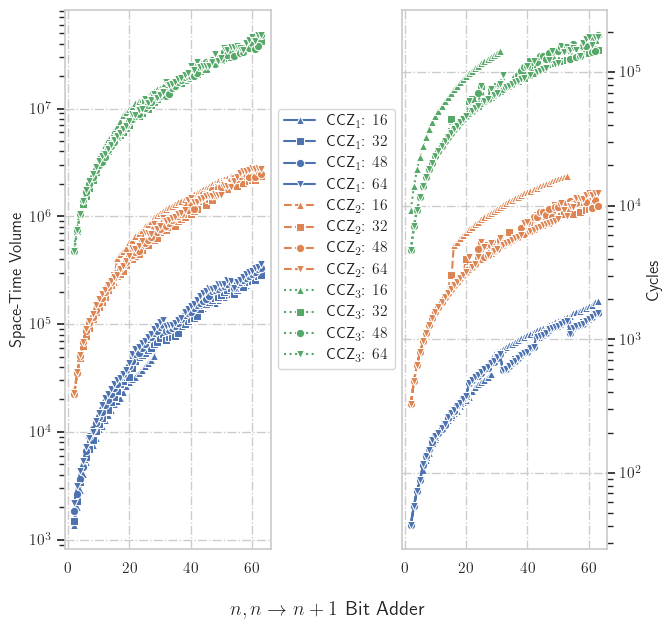

In [13]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

#f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#plt.grid(True,which="both")  


marks = ['^', 's', 'o', 'v']
linestyles = ['-', '--', ':']

target_key = 'distillery'
dependent = 'volume'
independent = 'adder'
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

ax = [
    plt.subplot2grid((1, 5), (0, 0), colspan=2),
    plt.subplot2grid((1, 5), (0, 3), colspan=2)
]

subplot = ax[0]
kwargs = {
'errorbar':('ci', 100)
}

for idx, target in enumerate((1, 2, 3)):
    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_ccz,
                independent,
                dependent,
                height=size,
                **{target_key:target}
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )
subplot.legend_.remove()
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'

subplot = ax[1]
for idx, target in enumerate((1, 2, 3)):

    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_ccz,
                independent,
                dependent,
                height=size,
                **{target_key:target}
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )


subplot = ax[1]
for idx, target in enumerate((1, 2, 3)):

    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_ccz,
                independent,
                dependent,
                height=size,
                **{target_key:target}
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )
subplot.legend_.remove()
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')
subplot.set_ylabel('Cycles')

fig = plt.gcf()
fig.set_size_inches(7, 7)

lines = linestyles * 3
labels = sum(([f'DAG$_{target}$', f'Extern$_{target}$', f'CCZ$_{target}$'] for target in range(3)), start=list())

handles, labels = subplot.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0.419, 0.75))
fig.supxlabel('$n, n \\rightarrow n + 1$ Bit Adder')


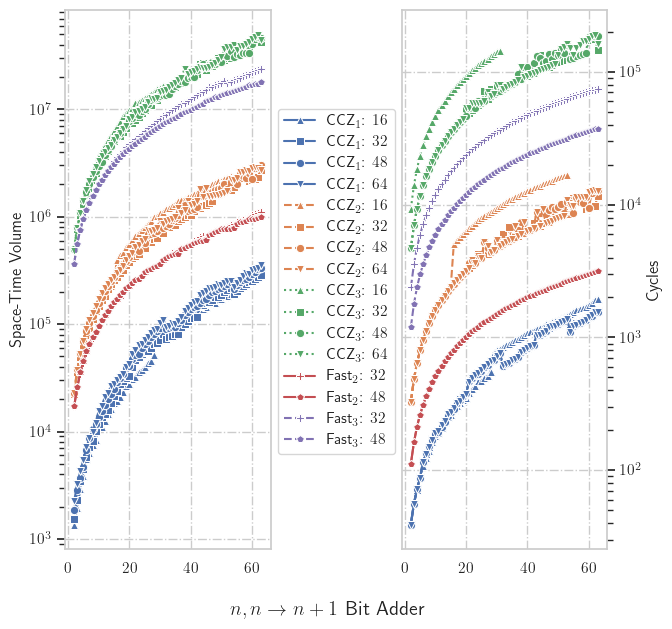

In [35]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

marks = ['^', 's', 'o', 'v']

marks_fast = ['P', 'p'] * 3

linestyles = ['-', '--', ':']

target_key = 'distillery'
dependent = 'volume'
independent = 'adder'
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

ax = [
    plt.subplot2grid((1, 5), (0, 0), colspan=2),
    plt.subplot2grid((1, 5), (0, 3), colspan=2)
]

subplot = ax[0]
kwargs = {
'errorbar':('ci', 100)
}

for idx, target in enumerate((1, 2, 3)):
    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_ccz,
                independent,
                dependent,
                height=size,
                **{target_key:target}
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )

for idx, target in enumerate((2, 3)):
    for jdx, size in enumerate([32, 48]):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_ccz_fast,
                independent,
                dependent,
                height=size,
                **{target_key:target}
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks_fast[jdx],
            color=sbs.color_palette()[idx + 3],
            **kwargs
        )

subplot.legend_.remove()
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'

subplot = ax[1]
for idx, target in enumerate((1, 2, 3)):

    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_ccz,
                independent,
                dependent,
                height=size,
                **{target_key:target}
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )


subplot = ax[1]
for idx, target in enumerate((2, 3)):

    for jdx, size in enumerate([32, 48]):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_ccz_fast,
                independent,
                dependent,
                height=size,
                **{target_key:target}
            ),
            label=f'Fast$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks_fast[jdx],
            color=sbs.color_palette()[idx + 3],
            **kwargs
        )
subplot.legend_.remove()
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')
subplot.set_ylabel('Cycles')

fig = plt.gcf()
fig.set_size_inches(7, 7)

lines = linestyles * 3
labels = sum(([f'DAG$_{target}$', f'Extern$_{target}$', f'CCZ$_{target}$'] for target in range(3)), start=list())

handles, labels = subplot.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0.419, 0.75))
fig.supxlabel('$n, n \\rightarrow n + 1$ Bit Adder')

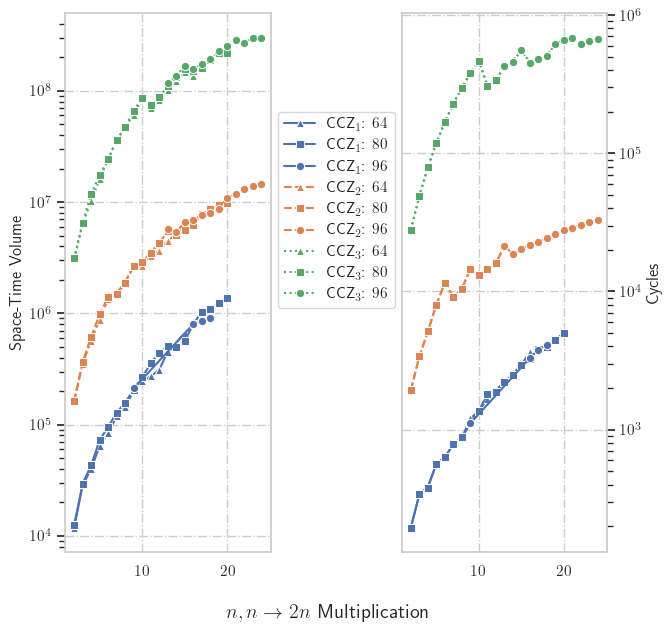

In [14]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})



sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

marks = ['^', 's', 'o', 'v']
linestyles = ['-', '--', ':']

target_key = 'distillery'
dependent = 'volume'
independent = 'adder'
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

ax = [
    plt.subplot2grid((1, 5), (0, 0), colspan=2),
    plt.subplot2grid((1, 5), (0, 3), colspan=2)
]

subplot = ax[0]
kwargs = {
'errorbar':('ci', 100)
}

for idx, target in enumerate((1, 2, 3)):
    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_mul,
                independent,
                dependent,
                height=size,
                **{target_key:target}
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )
subplot.legend_.remove()
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'

subplot = ax[1]
for idx, target in enumerate((1, 2, 3)):

    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_mul,
                independent,
                dependent,
                height=size,
                **{target_key:target}
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )
    
subplot.legend_.remove()
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')
subplot.set_ylabel('Cycles')

fig = plt.gcf()
fig.set_size_inches(7, 7)

lines = linestyles * 3
labels = sum(([f'DAG$_{target}$', f'Extern$_{target}$', f'CCZ$_{target}$'] for target in range(3)), start=list())

handles, labels = subplot.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0.419, 0.75))
fig.supxlabel('$n, n \\rightarrow 2n + 1$ Multiplication')